In [9]:
import matplotlib.pyplot as plt
import os

# Números y Datos
import numpy as np

import networkx as nx

from networkx.algorithms.approximation import average_clustering

import community.community_louvain as cl


import pickle

In [6]:
# DATOS REDES:
# !wget -O terrorist.txt https://www.dropbox.com/scl/fi/2vl6hcazv5v13r7scodod/terrorist.txt?rlkey=l0n1rxbby6a8irtlyh1tbbweo&dl=1
# !wget -O email.txt https://www.dropbox.com/scl/fi/w5o34b0olg7xek4s42lml/email-Eu-core.txt?rlkey=g2561imdd4ssyrwfgywrotzwm&st=czqgmef0&dl=1
# !wget -O email_labels.txt  https://www.dropbox.com/scl/fi/ij3b6jul7ispiovt18sfm/email-Eu-core-department-labels.txt?rlkey=dqp60qw20pw7biil9cvti4u68&st=zij9wsi8&dl=1
# !wget -O email_pos.pkl https://www.dropbox.com/scl/fi/loeuul6gxq7uscd1m7ks8/email_positions.pkl?rlkey=caf194s8198pffo2zaq6767jz&st=kw0c3tu4&dl=1

In [10]:
#cargar datos grafos

def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def get_graph_pos(filename):
  with open(filename, 'rb') as f:
    posData = pickle.load(f)
  return posData

In [ ]:
#def 

SyntaxError: invalid syntax (1885169875.py, line 1)

In [11]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

In [12]:
email = read_graph('datasets/email.txt')
print('Email')
print(email)
print('Es dirigido?:',nx.is_directed(email))
print('Es pesado?:',nx.is_weighted(email))
print('Es conectado?:',nx.is_connected(email))
print('')

terr= read_graph_weighted('datasets/terrorist.txt')
print('Terrorist')
print(terr)
print('Es dirigido?:',nx.is_directed(terr))
print('Es pesado?:',nx.is_weighted(terr))
print('Es conectado?:',nx.is_connected(terr))
print('')

Email
Graph with 1005 nodes and 16706 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: False

Terrorist
Graph with 64 nodes and 243 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True



In [13]:
#calcular eficientemente en grafos muy grandes aproximación a distancias mínimas medias, $<d>$**
#sil: esta función no la vamos a usar no necesitamos samplear (borren si ok)

def sample_path_lengths(G, nodes=None, trials=1000):   #solo para redes muy grandes calcula la media entre una cantidad limitada de pares porque entre miles no tendría sentido.
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

¿Cómo eliminarle los pesos a un grafo pesado?:

In [14]:
TerroristUnweighted = terr.copy()
drop_weights(TerroristUnweighted)
TerroristUnweighted.remove_edges_from(nx.selfloop_edges(TerroristUnweighted)) #remuevo autoenlaces NO HAY
print('Terrorist Unweighted)')
print(TerroristUnweighted)
print('Es dirigido?:',nx.is_directed(TerroristUnweighted))
print('Es pesado?:',nx.is_weighted(TerroristUnweighted))
print('Es conectado?:',nx.is_connected(TerroristUnweighted))
print('')

Terrorist Unweighted)
Graph with 64 nodes and 243 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



In [15]:
#leer los labels del dataset email

array = np.loadtxt('datasets/email_labels.txt', dtype=int)
labelsEmail=list(array[:,1])
print(labelsEmail) # es una lista del label para cada nodo (por ej. el nodo 3 pertenece al departamento 21

[np.int64(1), np.int64(1), np.int64(21), np.int64(21), np.int64(21), np.int64(25), np.int64(25), np.int64(14), np.int64(14), np.int64(14), np.int64(9), np.int64(14), np.int64(14), np.int64(26), np.int64(4), np.int64(17), np.int64(34), np.int64(1), np.int64(1), np.int64(14), np.int64(9), np.int64(9), np.int64(9), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(5), np.int64(34), np.int64(14), np.int64(14), np.int64(17), np.int64(17), np.int64(10), np.int64(10), np.int64(36), np.int64(37), np.int64(5), np.int64(7), np.int64(4), np.int64(22), np.int64(22), np.int64(21), np.int64(21), np.int64(21), np.int64(21), np.int64(7), np.int64(7), np.int64(36), np.int64(21), np.int64(25), np.int64(4), np.int64(8), np.int64(15), np.int64(15), np.int64(15), np.int64(37), np.int64(37), np.int64

In [16]:
#componente gigante del grafo Email

Gemail=email
Gemail.remove_edges_from(nx.selfloop_edges(Gemail)) # Borro autoenlaces
Gemailcc = sorted(nx.connected_components(Gemail), key=len, reverse=True)
emailGiant = Gemail.subgraph(Gemailcc[0])
print(emailGiant)
print('Es dirigido?:',nx.is_directed(emailGiant))
print('Es pesado?:',nx.is_weighted(emailGiant))
print('emailGiant Es conectado?:',nx.is_connected(emailGiant))
print('')

Graph with 986 nodes and 16064 edges
Es dirigido?: False
Es pesado?: False
emailGiant Es conectado?: True



### Spring Layout: posición espacial de los nodos en el grafo
Para graficar grafos, es útil usar el layout de "resortes" para encontrar una posición espacial "óptima" de los nodos ("óptima" en el sentido que representa mejor la organización general del grafo).

Para obtener este layout, se considera una lucha entre dos fuerzas antagónicas: una en la que los nodos se "repelen" entre sí, y otra en la que los pares de nodos conectados se acercan gracias a los enlaces que los unen (que funcionan como "resortes"). De esta manera los nodos más interconectados van a agruparse en una posición espacial del grafo. La simulación corre un número de iteriaciones (controlada por el parámetro $iterations$) hasta llegar a un equilibrio.

*Opcional:* un parámetro extra opcional, el parámetro $k$, que fuerza una distancia óptima entre nodos (cuanto menor más se agrupan todos los nodos en el centro; si lo agrando va a posicionar los nodos menos conectados más en la periferia del grafo). Esto serviría si luego de correr la simulación, el layout resultante es una bola de nodos en el centro. En ese caso hay que probar a mano con varios valores de $k$ (en el rango 0.1 - 10, por ejemplo) para ver si mejora el layout.

In [ ]:
# Se corre así para un grafo "G", y me devuelve un diccionario "pos" de posiciones
pos = nx.spring_layout(email,iterations=1000)

# Opcional, con parámetro "k"
# pos = nx.spring_layout(G,iterations=1000, k=0.5)

Para grafos muy grandes puede demorar (por ej., 20 mins para el grafo de Facebook), así que estas son las posiciones pre-computadas (con $iterations$=1000 y $k$=None):

In [ ]:
pos_email=get_graph_pos('datasets/email_pos.pkl')

In [ ]:
pos_email

{np.int64(0): array([-0.01379673, -0.09166854]),
 np.int64(1): array([-0.0567902 , -0.11811211]),
 np.int64(2): array([-0.10547947,  0.12816052]),
 np.int64(3): array([-0.1024727 ,  0.11226833]),
 np.int64(4): array([-0.10609515,  0.08553103]),
 np.int64(5): array([-0.00387222,  0.02298802]),
 np.int64(6): array([-0.0536365 ,  0.01478425]),
 np.int64(7): array([0.13640143, 0.10056733]),
 np.int64(8): array([0.15142713, 0.13630746]),
 np.int64(9): array([0.2412004 , 0.17182244]),
 np.int64(10): array([0.02798097, 0.09446552]),
 np.int64(11): array([0.08996872, 0.08312573]),
 np.int64(12): array([0.13528293, 0.09925083]),
 np.int64(13): array([0.01263638, 0.01143482]),
 np.int64(14): array([ 0.08662601, -0.11499811]),
 np.int64(15): array([-0.00498058,  0.14909415]),
 np.int64(16): array([-0.02766176,  0.00163312]),
 np.int64(17): array([-0.04915729, -0.05717269]),
 np.int64(18): array([-0.00456072, -0.12969546]),
 np.int64(19): array([0.08296678, 0.08163808]),
 np.int64(20): array([-0.1

In [ ]:
pos

{np.int64(0): array([-0.00140138, -0.00077493]),
 np.int64(1): array([-0.00166893, -0.00043422]),
 np.int64(2): array([ 0.00117128, -0.0027026 ]),
 np.int64(3): array([ 0.00089402, -0.00258817]),
 np.int64(4): array([ 0.0007248, -0.0024869]),
 np.int64(5): array([-0.00019232, -0.00164087]),
 np.int64(6): array([-0.00020164, -0.00196232]),
 np.int64(7): array([0.00124156, 0.00056115]),
 np.int64(8): array([0.00165974, 0.00066907]),
 np.int64(9): array([0.00224067, 0.0017445 ]),
 np.int64(10): array([ 0.00096241, -0.00050786]),
 np.int64(11): array([9.99164535e-04, 5.18842317e-05]),
 np.int64(12): array([0.00118002, 0.00039522]),
 np.int64(13): array([-0.00027763, -0.00102486]),
 np.int64(14): array([-1.90999394e-03, -7.53813219e-05]),
 np.int64(15): array([-7.32382296e-06, -3.06021492e-03]),
 np.int64(16): array([-0.00048803, -0.0015807 ]),
 np.int64(17): array([-0.00098499, -0.00093527]),
 np.int64(18): array([-0.00190339, -0.00058034]),
 np.int64(19): array([8.70996795e-04, 3.68269139

Calculo de antemano las posiciones para el resto de los grafos:

In [ ]:
pos_terr = nx.spring_layout(terr,iterations=1000)


### ¿Cómo graficar redes pesadas?
Ahora defino una función útil para graficar redes pesadas donde el ancho de los enlaces es proporcional al peso. Puede ser un proceso lento si el grafo es demasiado grande (en ese caso usar nx.draw como siempre y no darle diferentes anchos a los enlaces).

El parametro $magnification$ calibra cuanto se suaviza o exagera la diferencia entre los anchos de los enlaces.
El parámetro $colorMapping$ es un diccionario donde a cada nodo se le asigna un valor numérico que se puede mapear a un color. Por ej., puede ser la centralidad de un nodo, que se va a representar en una escala de colores

In [ ]:
def plotWeightedGraph(G,pos,colorMapping,magnification,nodeSize=45):
  values = [v for n,v in colorMapping.items()]
  nx.draw_networkx_nodes(G,pos=pos,node_size=nodeSize, node_color = values)
  nx.draw_networkx_labels(G,pos,{n:n for n in G.nodes()},font_size=7,font_color='white')

  edge_weights = nx.get_edge_attributes(G, "weight")
  edgeWidths=np.array(list(edge_weights.values()))
  edgeWidths=magnification*edgeWidths/np.max(edgeWidths)
  edgeWidths[edgeWidths>0]=edgeWidths[edgeWidths>0]-np.min(edgeWidths[edgeWidths>0])+.5

  nx.draw_networkx_edges(G, pos, edgelist=G.edges(),width=edgeWidths,edge_color='gray')


Por ejemplo, para el dataset *Terroristas*:



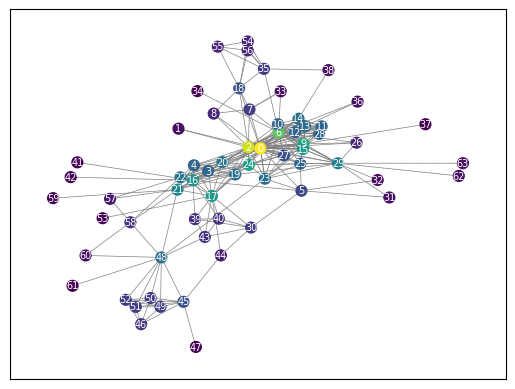

In [ ]:
G=terr
centrality = nx.degree_centrality(G)  #color representa centralidad de nodo
magnification=1 #se puede modificar para resaltar los enlaces
nodeSize=60
plotWeightedGraph(G,pos_terr,centrality,magnification,nodeSize)

### ¿Cómo resaltamos un atributo de un nodo (por ej., centralidad) al graficar un grafo?

In [ ]:
def plotNodeAttribute(G,pos,attribute,exaggeration): #definir el atributo para magnificarlo con esta función por ejemplo tamaño del nodo segun centralidad
  values = [v for n,v in attribute.items()]
  nsize = np.array (values)
  nsize = exaggeration*( nsize - min(nsize))/(max(nsize) - min(nsize))
  nx.draw(G,pos=pos, node_size = nsize, alpha=0.4,node_color = values, edge_color='gray')

Por ejemplo, para el dataset *Terroristas* (obviando el peso de los enlaces):


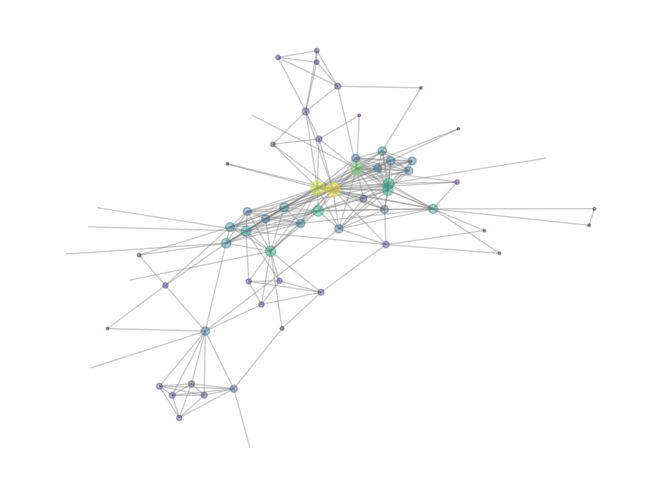

In [ ]:
exaggeration=100
plotNodeAttribute(G,pos_terr,centrality,exaggeration)  #por color y por tamaño

Graph with 986 nodes and 16064 edges
emailGiant Es dirigido?: False
emailGiant Es pesado?: False
emailGiant emailGiant Es conectado?: True
emailGiant Grado promedio <k>: 32.58
emailGiant Nodo con grado máximo: 160 con k_max = 345
emailGiant Nodo con grado mínimo: 449 con k_min = 1
emailGiant: el nodo con mayor grado es el 160, que posee 345 enlaces
emailGiant Coeficiente de clustering promedio <C>: 0.41
La distancia media de la componente gigante de emailEU es: 2.59
emailGiant Eficiencia global: 0.42


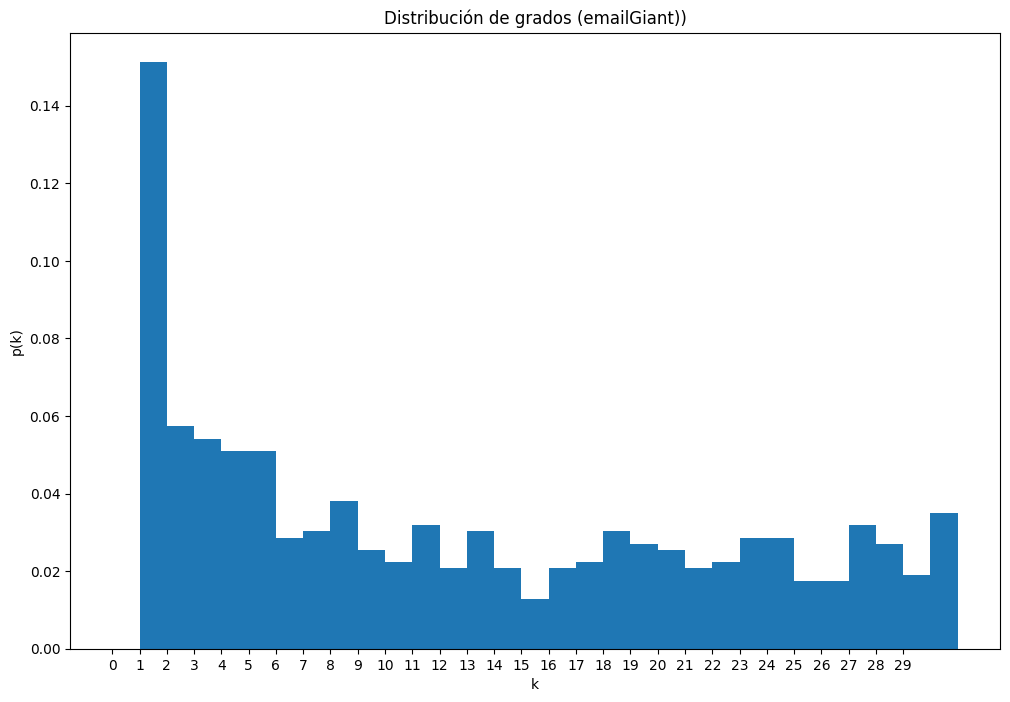

In [ ]:
#SIL exploratorio emailEU componente gigante = emailGiant

print(emailGiant)
print('emailGiant Es dirigido?:',nx.is_directed(emailGiant))
print('emailGiant Es pesado?:',nx.is_weighted(emailGiant))
print('emailGiant emailGiant Es conectado?:',nx.is_connected(emailGiant))

degrees_emailGiant = [d for n, d in emailGiant.degree()]

k_promedio_emailGiant = round(sum(degrees_emailGiant) / len(degrees_emailGiant), 2)
print("emailGiant Grado promedio <k>:", k_promedio_emailGiant)

nodo_max_emailGiant, k_max_emailGiant = max(emailGiant.degree(), key=lambda x: x[1])
print("emailGiant Nodo con grado máximo:", nodo_max_emailGiant, "con k_max =", k_max_emailGiant)
nodo_min_emailGiant, k_min_emailGiant = min(emailGiant.degree(), key=lambda x: x[1])
print("emailGiant Nodo con grado mínimo:", nodo_min_emailGiant, "con k_min =", k_min_emailGiant)

sortedNodes_emailGiant = sorted(emailGiant.degree, key=lambda x: x[1], reverse=True) #lista ordenada de tuplas nodo, grado, x[1] es el grado
print(f'emailGiant: el nodo con mayor grado es el {sortedNodes_emailGiant[0][0]}, que posee {sortedNodes_emailGiant[0][1]} enlaces' ) #0 0 es tupla 0 posición 0

C_emailGiant = round(nx.average_clustering(emailGiant), 2)
print("emailGiant Coeficiente de clustering promedio <C>:", C_emailGiant)

d_media_emailGiant = round(nx.average_shortest_path_length(emailGiant),2)
print("La distancia media de la componente gigante de emailEU es:", d_media_emailGiant)

efficiency_emailGiant = round(nx.global_efficiency(emailGiant),2)
print("emailGiant Eficiencia global:", efficiency_emailGiant)


In [22]:
#SIL exploratorio terroristas sin peso = TerroristUnweighted

print('Terrorist Unweighted)')
print(TerroristUnweighted)
print('TerroristUnweighted Es dirigido?:',nx.is_directed(TerroristUnweighted))
print('TerroristUnweighted Es pesado?:',nx.is_weighted(TerroristUnweighted))
print('TerroristUnweighted Es conectado?:',nx.is_connected(TerroristUnweighted))

degrees_TerroristUnweighted = [d for n, d in TerroristUnweighted.degree()]

k_promedio_TerroristUnweighted = round(sum(degrees_TerroristUnweighted) / len(degrees_TerroristUnweighted), 2)
print("TerroristUnweighted Grado promedio <k>:", k_promedio_TerroristUnweighted)

nodo_max_TerroristUnweighted, k_max_TerroristUnweighted = max(TerroristUnweighted.degree(), key=lambda x: x[1])
print("TerroristUnweighted Nodo con grado máximo:", nodo_max_TerroristUnweighted, "con k_max =", k_max_TerroristUnweighted)
nodo_min_TerroristUnweighted, k_min_TerroristUnweighted = min(TerroristUnweighted.degree(), key=lambda x: x[1])
print("TerroristUnweighted Nodo con grado mínimo:", nodo_min_TerroristUnweighted, "con k_min =", k_min_TerroristUnweighted)

sortedNodes_TerroristUnweighted = sorted(TerroristUnweighted.degree, key=lambda x: x[1], reverse=True) #lista ordenada de tuplas nodo, grado, x[1] es el grado
print(f'TerroristUnweighted: el nodo con mayor grado es el {sortedNodes_TerroristUnweighted[0][0]}, que posee {sortedNodes_TerroristUnweighted[0][1]} enlaces' ) #0 0 es tupla 0 posición 0

C_TerroristUnweighted = round(nx.average_clustering(TerroristUnweighted), 2)
print("TerroristUnweighted Coeficiente de clustering promedio <C>:", C_TerroristUnweighted)

d_media_TerroristUnweighted = round(nx.average_shortest_path_length(TerroristUnweighted),2)
print("La distancia media de Terrorist (sin pesos) es:", d_media_TerroristUnweighted)

efficiency_TerroristUnweighted = round(nx.global_efficiency(TerroristUnweighted),2)
print("TerroristUnweighted Eficiencia global:", efficiency_TerroristUnweighted)

# falta distribución de grado (estoy en eso)

Terrorist Unweighted)
Graph with 64 nodes and 243 edges
TerroristUnweighted Es dirigido?: False
TerroristUnweighted Es pesado?: False
TerroristUnweighted Es conectado?: True
TerroristUnweighted Grado promedio <k>: 7.59
TerroristUnweighted Nodo con grado máximo: 0 con k_max = 29
TerroristUnweighted Nodo con grado mínimo: 34 con k_min = 1
TerroristUnweighted: el nodo con mayor grado es el 0, que posee 29 enlaces
TerroristUnweighted Coeficiente de clustering promedio <C>: 0.62
La distancia media de Terrorist (sin pesos) es: 2.69
TerroristUnweighted Eficiencia global: 0.45


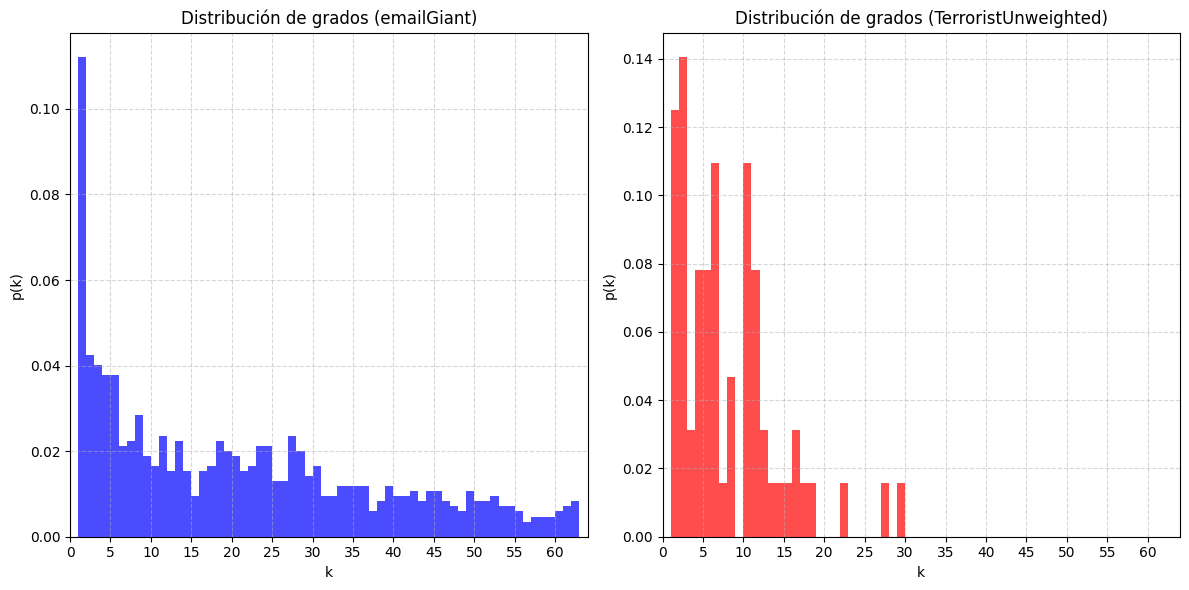

In [38]:
#SIL distribución de grado comparada bins = 64

degreesdg_emailGiant = [emailGiant.degree(n) for n in emailGiant.nodes()] #guarda los grados de todos los nodos
degreesdg_terrorists = [TerroristUnweighted.degree(n) for n in TerroristUnweighted.nodes()]

bins = np.arange(0, 64, 1) # por qué 64? porque es el doble del k promedio de email. solo una opción

plt.figure(figsize=(12, 6))

plt.subplot(121) #grilla de graficos, 1 fila 3 columnas, 1 orden
plt.hist(degreesdg_emailGiant, bins=bins, density=True, color='blue', alpha=0.7)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados (emailGiant)')
plt.xticks(np.arange(0, 65, 5))
plt.xlim(0, 64)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(122)
plt.hist(degreesdg_terrorists, bins=bins, density=True, color='red', alpha=0.7)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados (TerroristUnweighted)')
plt.xticks(np.arange(0, 65, 5))
plt.xlim(0, 64)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


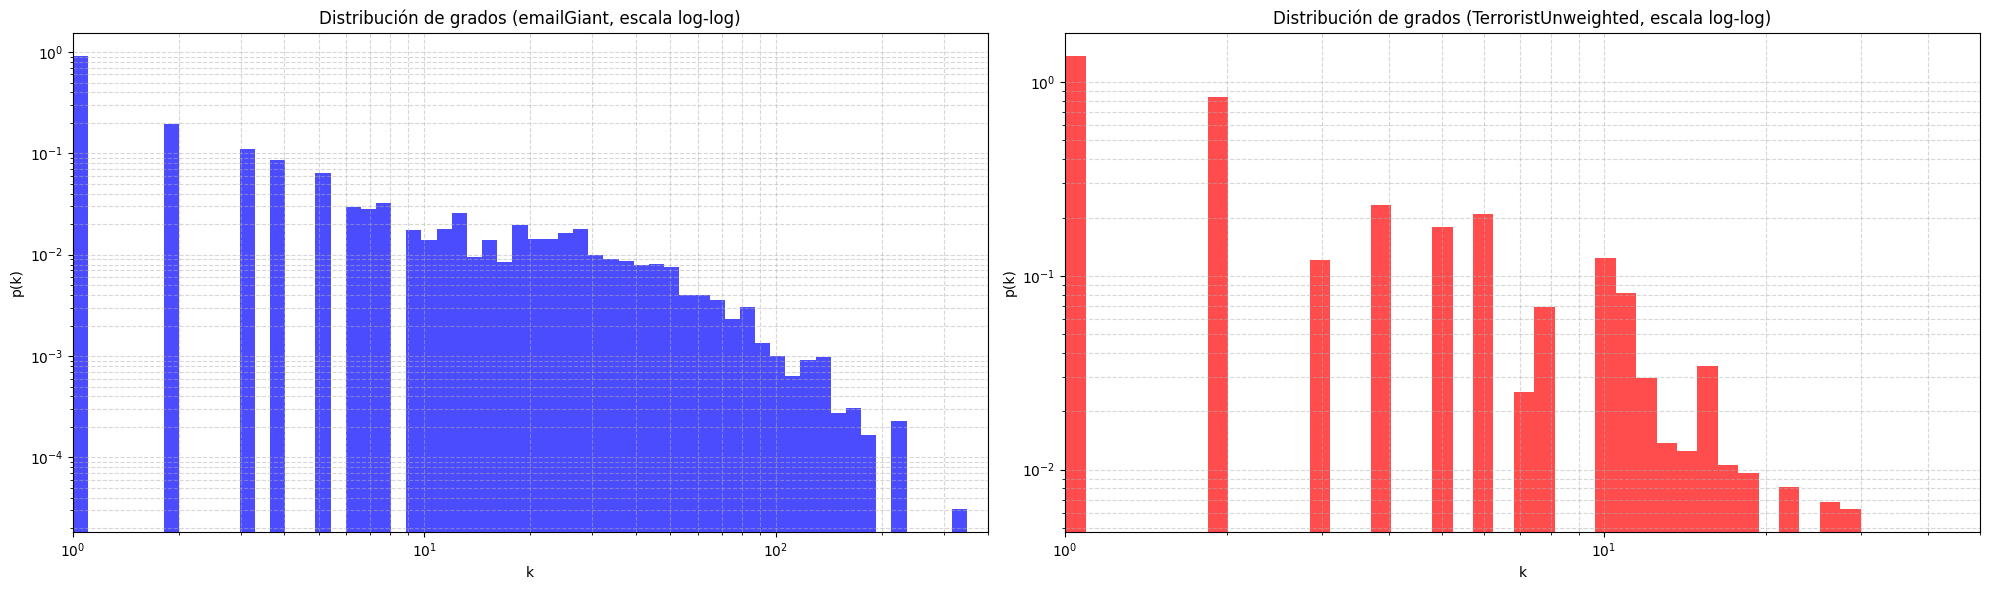

In [37]:
#SIL distribución de grado comparada escala logartimica

plt.figure(figsize=(20, 6))

bins_log_email = np.logspace(0, np.log10(350), num=60)  # más suave
bins_log_terrorist = np.logspace(0, np.log10(30), num=40)  # a su máximo

plt.subplot(121) 
plt.hist(degreesdg_emailGiant, bins=bins_log_email, density=True, color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados (emailGiant, escala log-log)')
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.xlim(1, 400)  # extendemos hasta 400 para captar toda la cola

plt.subplot(122) 
plt.hist(degreesdg_terrorists, bins=bins_log_terrorist, density=True, color='red', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribución de grados (TerroristUnweighted, escala log-log)')
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.xlim(1, 50)  #no tiene grados altos, limitamos para ver mejor

plt.tight_layout()
plt.show()
